<a href="https://colab.research.google.com/github/carbaluar/Presentaci-n/blob/main/CRR_impurezas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Se evalúa el efecto catalizador de impurezas (Na,Ca,S) en la carboxirreactividad**

### Carga de datos

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import sqlite3
import datetime

In [2]:
df = pd.read_excel('/content/DBImpurezas.xlsx')
df.head()

,SODIO,CALCIO,VANADIO,HIERRO,AZUFRE,CRR,CRD,CRRbin
0,600,260,82,480,0.72,85.6581,3.5554,1
1,380,250,82,390,0.73,85.6581,3.5554,1
2,350,240,96,380,0.74,85.6581,3.5554,1
3,410,270,86,380,0.73,85.6581,3.5554,1
4,460,280,77,340,0.69,85.6581,3.5554,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2990 entries, 0 to 2989
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SODIO    2990 non-null   int64  
 1   CALCIO   2990 non-null   int64  
 2   VANADIO  2990 non-null   int64  
 3   HIERRO   2990 non-null   int64  
 4   AZUFRE   2990 non-null   float64
 5   CRR      2990 non-null   float64
 6   CRD      2990 non-null   float64
 7   CRRbin   2990 non-null   int64  
dtypes: float64(3), int64(5)
memory usage: 187.0 KB


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# divido entre train y test/validación en 70%/30%
df_train, df_test_validation = train_test_split(df, train_size=0.7, stratify = df["CRRbin"])

In [6]:

# divido entre train y test/validación en 15% y 15%
df_test, df_validation = train_test_split(df_test_validation, train_size=0.5, stratify = df_test_validation["CRRbin"])

In [7]:
df_train.shape

(2093, 8)

In [8]:
df_test.shape

(448, 8)

In [9]:
df_validation.shape

(449, 8)

### Modelo Gaussiano

In [10]:
from sklearn.naive_bayes import GaussianNB

In [11]:
clf = GaussianNB(priors=None, var_smoothing= 0.1)

In [12]:
df_train2 = df_train[["SODIO","CALCIO","AZUFRE","CRRbin"]].copy()

In [13]:
clf.fit(df_train2.drop("CRRbin",axis=1), df_train2["CRRbin"])

GaussianNB(priors=None, var_smoothing=0.1)

In [14]:
clf.score(df_train2.drop("CRRbin",axis=1), df_train2["CRRbin"])

0.5652173913043478

In [15]:
df_validation2 = df_validation[["SODIO","CALCIO","AZUFRE","CRRbin"]].copy()
df_test_validation2 = df_test_validation[["SODIO","CALCIO","AZUFRE","CRRbin"]].copy()

In [16]:
clf.score(df_validation2.drop("CRRbin",axis=1), df_validation2["CRRbin"])


0.5657015590200446

In [17]:
BuscaSmoot = [0.1, 0.001, 0.0001, 0.00001, 0.000001, 0.000000000001]

In [18]:
scores = list()
for busca in BuscaSmoot:
    clf = GaussianNB(var_smoothing = busca)
    clf.fit(df_train2.drop("CRRbin",axis=1), df_train2["CRRbin"])
    scores.append(clf.score(df_validation2.drop("CRRbin",axis=1), df_validation2["CRRbin"]))

print("Máximo score con un smoothing de: ", BuscaSmoot[scores.index(max(scores))], "--> valor de Score: ", max(scores))

Máximo score con un smoothing de:  1e-12 --> valor de Score:  0.6146993318485523


####Dato Obtenido

In [19]:
from sklearn.metrics import confusion_matrix, roc_auc_score
import numpy as np
df_train2.head()

,SODIO,CALCIO,AZUFRE,CRRbin
1133,336,192,0.92,1
1088,469,182,0.83,0
1884,390,180,0.57,0
2492,352,180,0.94,0
508,318,214,0.78,0


In [20]:
clf.predict(np.array([[400,300,0.7]]))

array([0])

#### Matriz

In [21]:
y_true = 1*np.array(df_validation2["CRRbin"])

In [22]:
y_pred = clf.predict_proba(df_validation2.drop("CRRbin",axis=1))

In [23]:
print("Matriz de Confusión Alfa 0.25")
print(confusion_matrix(y_true,y_pred[:,1]>0.25))

Matriz de Confusión Alfa 0.25
[[ 17 237]
 [  5 190]]


In [24]:
from sklearn.metrics import fbeta_score

In [25]:
print("Valor de F1 para un alfa= 0.25 -->", fbeta_score(y_true, y_pred[:,1]>0.25, beta=1))

Valor de F1 para un alfa= 0.25 --> 0.6109324758842444


In [26]:
print("Valor de Fbetascore para un alfa= 0.25 -->", fbeta_score(y_true, y_pred[:,1]>0.25, beta=2))

Valor de Fbetascore para un alfa= 0.25 --> 0.7870753935376966


In [27]:
alfa = 0.02
recalls = np.zeros(100)
precisions= np.zeros(100)
FPR = np.zeros(100)
alfas = np.linspace(0,1,100)
for idx,alfa in enumerate(alfas):
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred[:,1]>alfa).ravel()
    recalls[idx] = (tp/(tp+fn))
    precisions[idx] = (tp/(tp+fp))
    FPR[idx]= (fp/(fp+tn))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


In [28]:
print("Para un alfa 0.25 --> Valor de recall", recalls[25], "Valor de Precisions", precisions[25], "Valor de FPR", FPR[25])
print("Para un alfa 0.5 --> Valor de recall", recalls[50], "Valor de Precisions", precisions[50], "Valor de FPR", FPR[50])
print("Para un alfa 0.75 --> Valor de recall", recalls[75], "Valor de Precisions", precisions[75], "Valor de FPR", FPR[75])

Para un alfa 0.25 --> Valor de recall 0.9743589743589743 Valor de Precisions 0.4449648711943794 Valor de FPR 0.9330708661417323
Para un alfa 0.5 --> Valor de recall 0.29743589743589743 Valor de Precisions 0.6444444444444445 Valor de FPR 0.12598425196850394
Para un alfa 0.75 --> Valor de recall 0.0 Valor de Precisions nan Valor de FPR 0.0


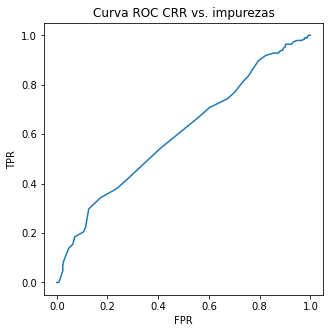

In [29]:
plt.figure(figsize=[5,5])
plt.plot(FPR,recalls)
plt.title("Curva ROC CRR vs. impurezas")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

### Modelo LDA

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [31]:
LDA_clf = LinearDiscriminantAnalysis()

In [32]:
LDA_clf.fit(df_train2.drop("CRRbin",axis=1), df_train2["CRRbin"])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [33]:
LDA_clf.score(df_train2.drop("CRRbin",axis=1), df_train2["CRRbin"])

0.5647396082178691

In [34]:
LDA_clf.score(df_validation2.drop("CRRbin",axis=1), df_validation2["CRRbin"])

0.5991091314031181

In [35]:
LDA_clf.predict(np.array([[300,500,0.8]]))

array([0])

In [36]:
y_true2 = 1*np.array(df_test_validation2["CRRbin"])

In [37]:
y_pred_LDA = LDA_clf.predict_proba(df_test_validation2.drop("CRRbin",axis=1))

In [38]:
print("Matriz de Confusión Alfa 0.25")
print(confusion_matrix(y_true2,y_pred_LDA[:,1]>0.25))

Matriz de Confusión Alfa 0.25
[[  3 504]
 [  2 388]]


In [39]:
alfa = 0.02
recalls = np.zeros(100)
precisions= np.zeros(100)
FPR = np.zeros(100)
alfas = np.linspace(0,1,100)
for idx,alfa in enumerate(alfas):
    tn, fp, fn, tp = confusion_matrix(y_true2,y_pred_LDA[:,1]>alfa).ravel()
    recalls[idx] = (tp/(tp+fn))
    precisions[idx] = (tp/(tp+fp))
    FPR[idx]= (fp/(fp+tn))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


In [40]:
print("Para un alfa 0.25 --> Valor de recall", recalls[25], "Valor de Precisions", precisions[25], "Valor de FPR", FPR[25])
print("Para un alfa 0.5 --> Valor de recall", recalls[50], "Valor de Precisions", precisions[50], "Valor de FPR", FPR[50])
print("Para un alfa 0.75 --> Valor de recall", recalls[75], "Valor de Precisions", precisions[75], "Valor de FPR", FPR[75])

Para un alfa 0.25 --> Valor de recall 0.9948717948717949 Valor de Precisions 0.43546576879910215 Valor de FPR 0.9921104536489151
Para un alfa 0.5 --> Valor de recall 0.18461538461538463 Valor de Precisions 0.576 Valor de FPR 0.10453648915187377
Para un alfa 0.75 --> Valor de recall 0.0 Valor de Precisions nan Valor de FPR 0.0


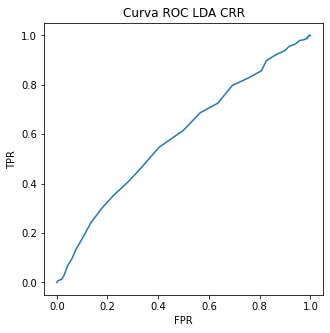

In [41]:
plt.figure(figsize=[5,5])
plt.plot(FPR,recalls)
plt.title("Curva ROC LDA CRR")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

### Modelo QDA

In [42]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
QDA_clf = QuadraticDiscriminantAnalysis()

In [43]:
QDA_clf.fit(df_train2.drop("CRRbin",axis=1), df_train2["CRRbin"])

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [44]:
QDA_clf.score(df_train2.drop("CRRbin",axis=1), df_train2["CRRbin"])

0.5618729096989966

In [45]:
QDA_clf.score(df_validation2.drop("CRRbin",axis=1), df_validation2["CRRbin"])

0.5946547884187082

In [46]:
QDA_clf.predict(np.array([[300,500,0.8]]))

array([0])

In [47]:
y_true2 = 1*np.array(df_test_validation2["CRRbin"])

In [48]:
y_pred_QDA = QDA_clf.predict_proba(df_test_validation2.drop("CRRbin",axis=1))

In [49]:
print("Matriz de Confusión Alfa 0.25")
print(confusion_matrix(y_true2,y_pred_QDA[:,1]>0.25))

Matriz de Confusión Alfa 0.25
[[ 12 495]
 [  6 384]]


In [50]:
alfa = 0.02
recalls = np.zeros(100)
precisions= np.zeros(100)
FPR = np.zeros(100)
alfas = np.linspace(0,1,100)
for idx,alfa in enumerate(alfas):
    tn, fp, fn, tp = confusion_matrix(y_true2,y_pred_QDA[:,1]>alfa).ravel()
    recalls[idx] = (tp/(tp+fn))
    precisions[idx] = (tp/(tp+fp))
    FPR[idx]= (fp/(fp+tn))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


In [51]:
print("Para un alfa 0.25 --> Valor de recall", recalls[25], "Valor de Precisions", precisions[25], "Valor de FPR", FPR[25])
print("Para un alfa 0.5 --> Valor de recall", recalls[50], "Valor de Precisions", precisions[50], "Valor de FPR", FPR[50])
print("Para un alfa 0.75 --> Valor de recall", recalls[75], "Valor de Precisions", precisions[75], "Valor de FPR", FPR[75])

Para un alfa 0.25 --> Valor de recall 0.9846153846153847 Valor de Precisions 0.43735763097949887 Valor de FPR 0.9743589743589743
Para un alfa 0.5 --> Valor de recall 0.20256410256410257 Valor de Precisions 0.5939849624060151 Valor de FPR 0.10650887573964497
Para un alfa 0.75 --> Valor de recall 0.0 Valor de Precisions nan Valor de FPR 0.0


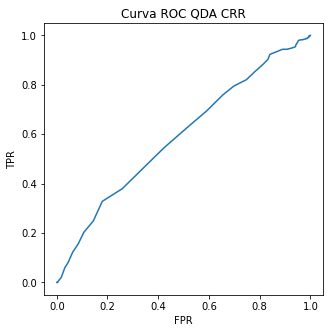

In [52]:
plt.figure(figsize=[5,5])
plt.plot(FPR,recalls)
plt.title("Curva ROC QDA CRR")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

### Modelo de Regresión Logística

In [53]:
from sklearn.linear_model import LogisticRegression
LR_clf=LogisticRegression(C=1e9, verbose=1)

In [54]:
LR_clf.fit(df_train2.drop("CRRbin",axis=1), df_train2["CRRbin"])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [55]:
LR_clf.score(df_train2.drop("CRRbin",axis=1), df_train2["CRRbin"])

0.5719063545150501

In [56]:
LR_clf.score(df_validation2.drop("CRRbin",axis=1), df_validation2["CRRbin"])

0.5991091314031181

In [57]:
LR_clf.predict(np.array([[300,500,0.8]]))

array([0])

In [58]:
y_true2 = 1*np.array(df_test_validation2["CRRbin"])

In [59]:
y_pred_LR = LR_clf.predict_proba(df_test_validation2.drop("CRRbin",axis=1))

In [60]:
print("Matriz de Confusión Alfa 0.25")
print(confusion_matrix(y_true2,y_pred_LR[:,1]>0.25))

Matriz de Confusión Alfa 0.25
[[  5 502]
 [  2 388]]


In [61]:
alfa = 0.02
recalls = np.zeros(100)
precisions= np.zeros(100)
FPR = np.zeros(100)
alfas = np.linspace(0,1,100)
for idx,alfa in enumerate(alfas):
    tn, fp, fn, tp = confusion_matrix(y_true2,y_pred_LR[:,1]>alfa).ravel()
    recalls[idx] = (tp/(tp+fn))
    precisions[idx] = (tp/(tp+fp))
    FPR[idx]= (fp/(fp+tn))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


In [62]:
print("Para un alfa 0.25 --> Valor de recall", recalls[25], "Valor de Precisions", precisions[25], "Valor de FPR", FPR[25])
print("Para un alfa 0.5 --> Valor de recall", recalls[50], "Valor de Precisions", precisions[50], "Valor de FPR", FPR[50])
print("Para un alfa 0.75 --> Valor de recall", recalls[75], "Valor de Precisions", precisions[75], "Valor de FPR", FPR[75])

Para un alfa 0.25 --> Valor de recall 0.9948717948717949 Valor de Precisions 0.4364454443194601 Valor de FPR 0.9881656804733728
Para un alfa 0.5 --> Valor de recall 0.18717948717948718 Valor de Precisions 0.5703125 Valor de FPR 0.10848126232741617
Para un alfa 0.75 --> Valor de recall 0.0 Valor de Precisions nan Valor de FPR 0.0


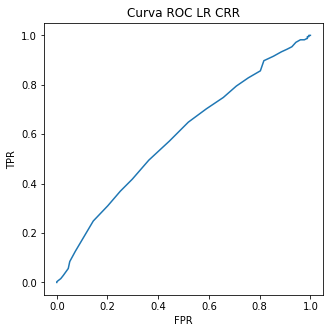

In [63]:
plt.figure(figsize=[5,5])
plt.plot(FPR,recalls)
plt.title("Curva ROC LR CRR")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

###Redes neuronales

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD

In [65]:
RN_clf= Sequential()
RN_clf.add(BatchNormalization(input_shape=(3,)))
RN_clf.add(Dense(16, input_dim=5, activation='relu'))
RN_clf.add(Dense(1, activation='sigmoid'))

In [66]:
RN_clf.compile(loss='mean_squared_error',
              optimizer='SGD',
              metrics=['binary_accuracy'])

In [68]:
RN_clf.fit(df_train2.drop("CRRbin",axis=1), df_train2["CRRbin"], epochs=300)

Epoch 1/300
66/66 [==============================] - 1s 1ms/step - loss: 0.2686 - binary_accuracy: 0.4749
Epoch 2/300
66/66 [==============================] - 0s 2ms/step - loss: 0.2625 - binary_accuracy: 0.4831
Epoch 3/300
66/66 [==============================] - 0s 1ms/step - loss: 0.2577 - binary_accuracy: 0.4936
Epoch 4/300
66/66 [==============================] - 0s 1ms/step - loss: 0.2558 - binary_accuracy: 0.5133
Epoch 5/300
66/66 [==============================] - 0s 1ms/step - loss: 0.2525 - binary_accuracy: 0.5153
Epoch 6/300
66/66 [==============================] - 0s 1ms/step - loss: 0.2489 - binary_accuracy: 0.5451
Epoch 7/300
66/66 [==============================] - 0s 1ms/step - loss: 0.2478 - binary_accuracy: 0.5546
Epoch 8/300
66/66 [==============================] - 0s 1ms/step - loss: 0.2474 - binary_accuracy: 0.5379
Epoch 9/300
66/66 [==============================] - 0s 1ms/step - loss: 0.2475 - binary_accuracy: 0.5537
Epoch 10/300
66/66 [==========================

In [69]:
y_pred_RN = RN_clf.predict_proba(df_test_validation2.drop("CRRbin",axis=1))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [70]:
print("Matriz de Confusión Alfa 0.25")
print(confusion_matrix(y_true2,y_pred_RN[:,0]>0.25))

Matriz de Confusión Alfa 0.25
[[  1 506]
 [  2 388]]


In [71]:
alfa = 0.02
recalls = np.zeros(100)
precisions= np.zeros(100)
FPR = np.zeros(100)
alfas = np.linspace(0,1,100)
for idx,alfa in enumerate(alfas):
    tn, fp, fn, tp = confusion_matrix(y_true2,y_pred_RN[:,0]>alfa).ravel()
    recalls[idx] = (tp/(tp+fn))
    precisions[idx] = (tp/(tp+fp))
    FPR[idx]= (fp/(fp+tn))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


In [72]:
print("Para un alfa 0.25 --> Valor de recall", recalls[25], "Valor de Precisions", precisions[25], "Valor de FPR", FPR[25])
print("Para un alfa 0.5 --> Valor de recall", recalls[50], "Valor de Precisions", precisions[50], "Valor de FPR", FPR[50])
print("Para un alfa 0.75 --> Valor de recall", recalls[75], "Valor de Precisions", precisions[75], "Valor de FPR", FPR[75])

Para un alfa 0.25 --> Valor de recall 0.9948717948717949 Valor de Precisions 0.43400447427293065 Valor de FPR 0.9980276134122288
Para un alfa 0.5 --> Valor de recall 0.24871794871794872 Valor de Precisions 0.49743589743589745 Valor de FPR 0.1932938856015779
Para un alfa 0.75 --> Valor de recall 0.0 Valor de Precisions nan Valor de FPR 0.0


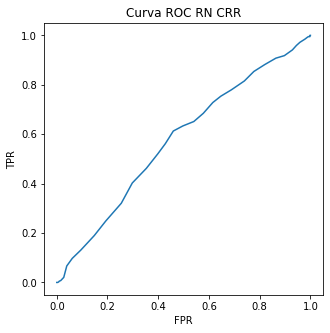

In [74]:
plt.figure(figsize=[5,5])
plt.plot(FPR,recalls)
plt.title("Curva ROC RN CRR")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()